In [1]:
import tensorflow as tf
import os

2022-11-27 20:19:02.590256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 20:19:03.138695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 20:19:03.138807: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-27 20:19:05.747367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [3]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [14]:
import cv2 
import imghdr
from matplotlib import pyplot as plt

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [20]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [22]:
import numpy as np

In [49]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 177 files belonging to 2 classes.


In [50]:
data_iterator = data.as_numpy_iterator()

In [51]:
#get another batch from the iterator
batch = data_iterator.next()


In [52]:
#class -1 = SAD
#class -0 = HAPPY
batch[1]

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int32)

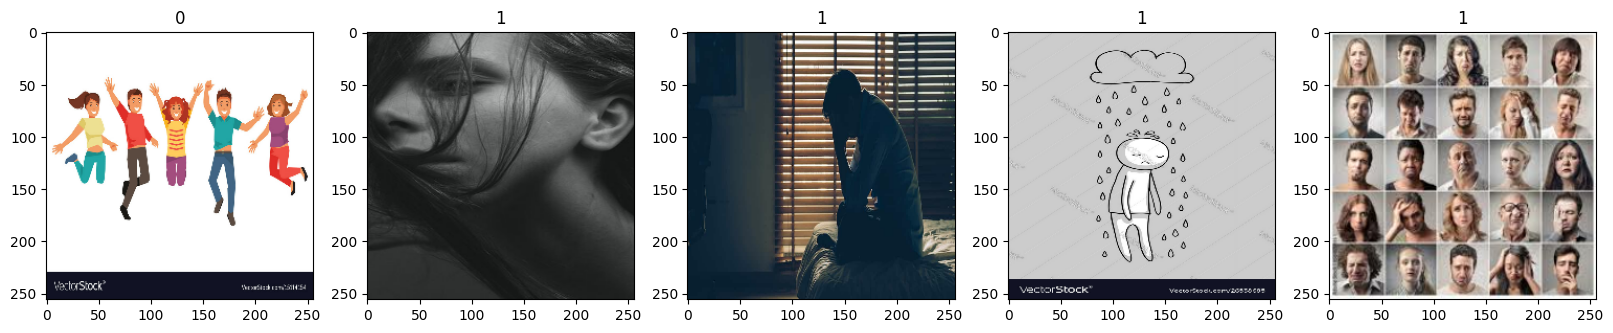

In [53]:
fig, ax = plt.subplots(ncols=5,figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [54]:
data = data.map(lambda x, y: (x/255, y))

In [55]:
data.as_numpy_iterator().next()[0].max()

1.0

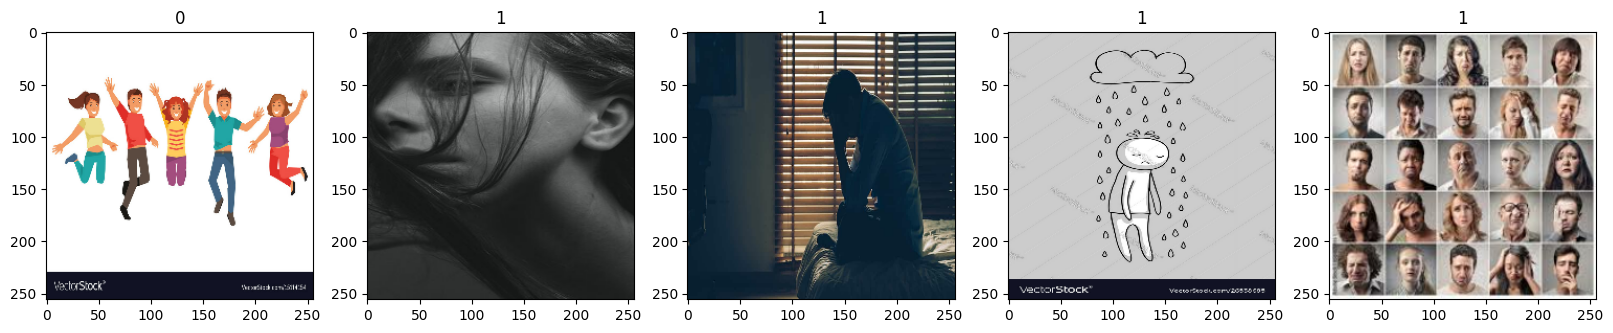

In [58]:
fig, ax = plt.subplots(ncols=5,figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

2.2 Split data

In [69]:
len(data)

6

In [70]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [72]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [75]:
len(test)

1

DEEP MODEL

3.1 Build Deep Learning Model

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Flatten, Dropout

In [113]:
model = Sequential()

In [114]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [115]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 30, 30, 16)      

In [117]:
log_dir = 'logs'

In [118]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [119]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 29s 5s/step - loss: 1.3162 - accuracy: 0.4141 - val_loss: 0.7078 - val_accuracy: 0.4375
Epoch 2/20
4/4 [==============================] - 18s 4s/step - loss: 0.6753 - accuracy: 0.5156 - val_loss: 0.6823 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 18s 4s/step - loss: 0.6254 - accuracy: 0.6016 - val_loss: 0.6200 - val_accuracy: 0.6875
Epoch 4/20
4/4 [==============================] - 17s 4s/step - loss: 0.5957 - accuracy: 0.6953 - val_loss: 0.5455 - val_accuracy: 0.6562
Epoch 5/20
4/4 [==============================] - 22s 6s/step - loss: 0.5511 - accuracy: 0.6797 - val_loss: 0.5786 - val_accuracy: 0.6562
Epoch 6/20
4/4 [==============================] - 16s 4s/step - loss: 0.5045 - accuracy: 0.7500 - val_loss: 0.3781 - val_accuracy: 0.8438
Epoch 7/20
4/4 [==============================] - 15s 4s/step - loss: 0.4418 - accuracy: 0.7969 - val_loss: 0.3125 - val_accuracy: 0.9062
Epoch 8/20
4/4 [==================

In [120]:
hist.history

{'loss': [1.3161938190460205,
  0.6752671003341675,
  0.625360369682312,
  0.5956916809082031,
  0.5511448383331299,
  0.5044772028923035,
  0.44176483154296875,
  0.33383727073669434,
  0.265169233083725,
  0.18755485117435455,
  0.18688151240348816,
  0.1569245457649231,
  0.1610618680715561,
  0.11288952082395554,
  0.08184998482465744,
  0.05498979613184929,
  0.04142692685127258,
  0.03319326043128967,
  0.02156248316168785,
  0.019660819321870804],
 'accuracy': [0.4140625,
  0.515625,
  0.6015625,
  0.6953125,
  0.6796875,
  0.75,
  0.796875,
  0.9140625,
  0.9296875,
  0.953125,
  0.96875,
  0.9609375,
  0.953125,
  0.96875,
  0.984375,
  1.0,
  0.9921875,
  0.9921875,
  1.0,
  1.0],
 'val_loss': [0.7078437805175781,
  0.6822529435157776,
  0.6200035810470581,
  0.5454713702201843,
  0.5785894393920898,
  0.3781064748764038,
  0.3124571740627289,
  0.2750314176082611,
  0.29027625918388367,
  0.17120608687400818,
  0.09515473246574402,
  0.13858488202095032,
  0.1010719388723373

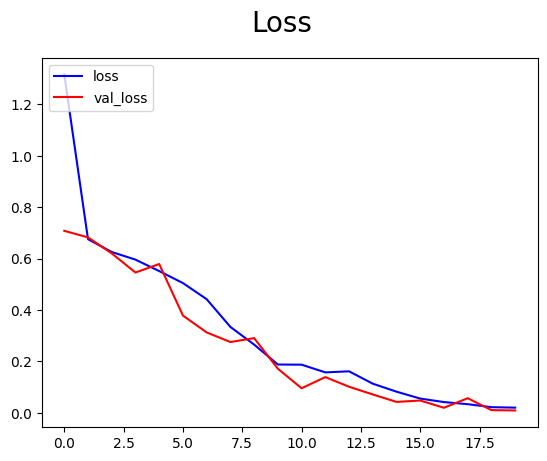

In [125]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

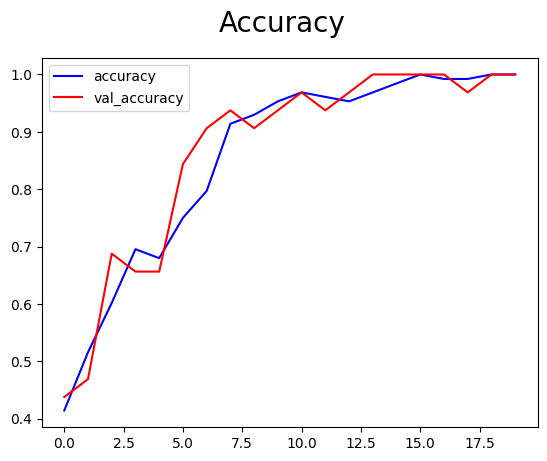

In [126]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

EVALUATE PERFORMANCE

4.1 Evaluate

In [127]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [128]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [129]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 790ms/step


In [131]:
print(f"Precision : {pre.result()}, Recall : {re.result()}, Accuracy : {acc.result()}")

Precision : 1.0, Recall : 1.0, Accuracy : 1.0


4.2 Test

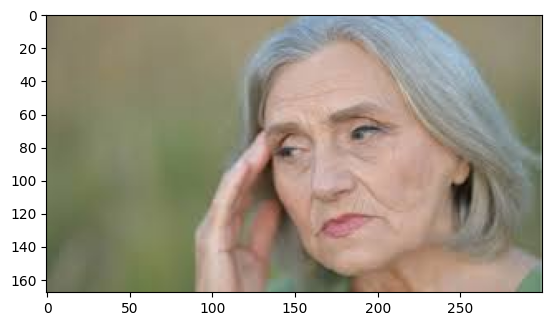

In [145]:
img = cv2.imread('sad-test.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

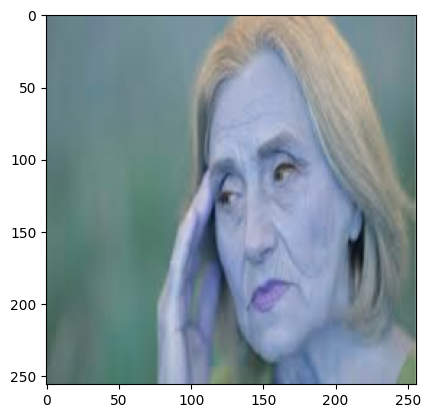

In [146]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [147]:
y_pred = model.predict(np.expand_dims(resize / 255, 0))

1/1 [==============================] - 0s 122ms/step


In [148]:
y_pred

array([[0.8304888]], dtype=float32)

In [150]:
if y_pred < 0.5:
    print("Predicted class is happy")
else:
    print("Predicted class is Sad")

Predicted class is Sad


SAVE MODEL

5.1 Save The Model

In [151]:
from tensorflow.keras.models import load_model

In [153]:
model.save(os.path.join('models', 'HappySadModel.h5'))

In [154]:
new_model = load_model(os.path.join('models', 'HappySadModel.h5'))

In [155]:
y_pred_new = new_model.predict(np.expand_dims(resize / 255, 0))

1/1 [==============================] - 1s 1s/step


In [156]:
if y_pred < 0.5:
    print("Predicted class is happy")
else:
    print("Predicted class is Sad")

Predicted class is Sad
